In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/ML.csv', parse_dates=['date'])
print(df.shape)
df.head()

(2340, 7)


typeofaction  sourceid  destinationid  amountofmoney                date   
0      cash-in     30105          28942         494528 2019-07-19 14:40:00  \
1      cash-in     30105           8692         494528 2019-05-17 14:57:00   
2      cash-in     30105          60094         494528 2019-07-20 13:20:00   
3      cash-in     30105          20575         494528 2019-07-03 14:15:00   
4      cash-in     30105          45938         494528 2019-05-26 10:40:00   

   isfraud typeoffraud  
0        1       type1  
1        1       type1  
2        1       type1  
3        1       type1  
4        1       type1

In this dataset only `amountofmoney` feature is a relevent numerical feature because `sourceid` and `destinationid` are **some sort of ids** which is not a feature at all.

In [3]:
tag_df = pd.read_csv('data/MLtag.csv')
print(tag_df.shape)
tag_df.head()

(1484, 3)


guiltyid levelofcrime typeofcrime
0     30105         head       type1
1     80740         head       type1
2     92735         head       type1
3      1615         head       type1
4      4161         head       type1

In [4]:
# final_df = df.merge(tag_df, 'inner', left_on='destinationid', right_on='guiltyid').info()

In [5]:
df.isnull().sum().sum()

0

There are no null values in the dataset.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   typeofaction   2340 non-null   object        
 1   sourceid       2340 non-null   int64         
 2   destinationid  2340 non-null   int64         
 3   amountofmoney  2340 non-null   int64         
 4   date           2340 non-null   datetime64[ns]
 5   isfraud        2340 non-null   int64         
 6   typeoffraud    2340 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 128.1+ KB


In [7]:
df.nunique()

typeofaction        2
sourceid         1749
destinationid    1710
amountofmoney     933
date             2309
isfraud             2
typeoffraud         4
dtype: int64

In [8]:
target = 'isfraud'
cat_cols = df.drop(columns=[target]).select_dtypes('object').columns.to_list()
num_cols = df.drop(columns=[target]).select_dtypes(['float', 'int']).columns.to_list()
date_col = 'date'

len(cat_cols), len(num_cols)

(2, 3)

In [9]:
df.duplicated().sum()

0

In [10]:
df.drop(columns=['sourceid', 'destinationid']).duplicated().sum()

0

## Categorical Columns

In [48]:
pd.crosstab(df['isfraud'], df['typeofaction'])

typeofaction    0    1
isfraud               
0             337  604
1             423  976

In [49]:
pd.crosstab(df['isfraud'], df['typeoffraud'])

typeoffraud    0    1    2    3
isfraud                        
0            941    0    0    0
1              0  423  465  511

1. `typeoffraud='none'` means there is no fraud at all.
2. Dataset has appox. equal number data point which fall into `type1`, `type2` and `type3` frauds which is a good indicator for model building.

### Encode the categorical columns

In [11]:
for col in cat_cols:
    print(f'{col}:  {df[col].unique().tolist()}')

typeofaction:  ['cash-in', 'transfer']
typeoffraud:  ['type1', 'type2', 'type3', 'none']


In [12]:
df['typeofaction'] = df['typeofaction'].map({'cash-in': 0, 'transfer': 1})
df['typeoffraud'] = df['typeoffraud'].map({'type1': 1, 'type2': 2, 'type3': 3, 'none': 0})

In [13]:
for col in ['typeofaction', 'typeoffraud']:
    print(f'{col}:  {df[col].unique().tolist()}')

typeofaction:  [0, 1]
typeoffraud:  [1, 2, 3, 0]


In [14]:
# Now move all cat_cols value to num_cols
num_cols.extend(cat_cols)
num_cols

['sourceid', 'destinationid', 'amountofmoney', 'typeofaction', 'typeoffraud']

### Work with `date`

In [32]:
dated_df = df.set_index('date').sort_index()

<Axes: xlabel='date', ylabel='amountofmoney'>

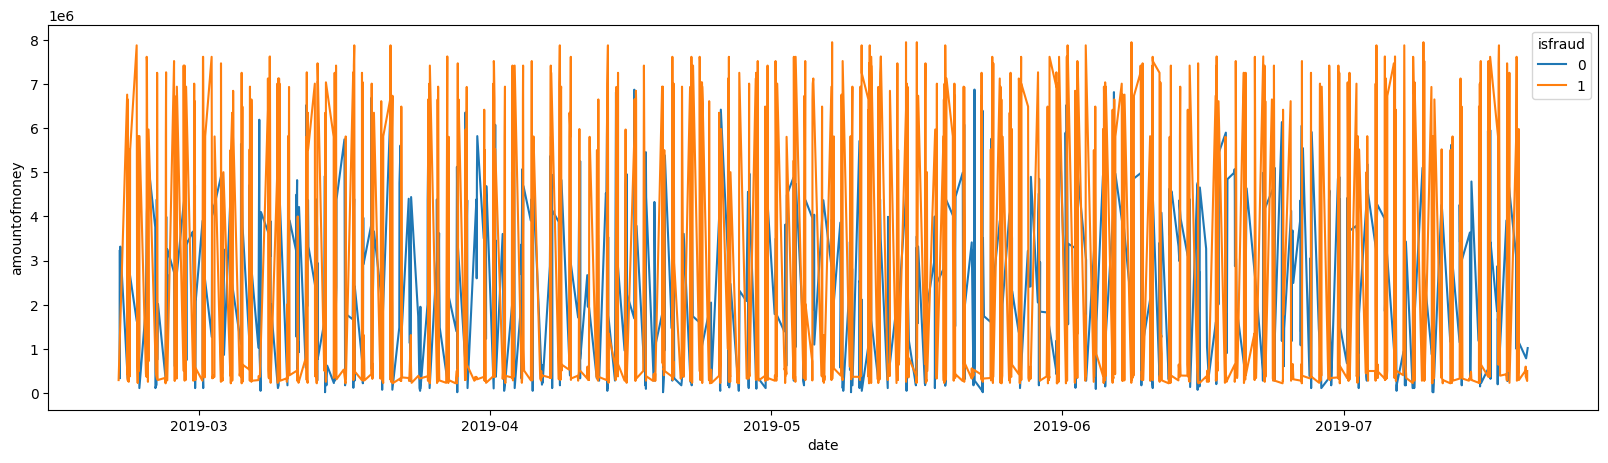

In [31]:
plt.figure(figsize=(20, 5))
sns.lineplot(dated_df, x=dated_df.index, y='amountofmoney',
             hue='isfraud', errorbar=('ci', False))

<Axes: xlabel='date'>

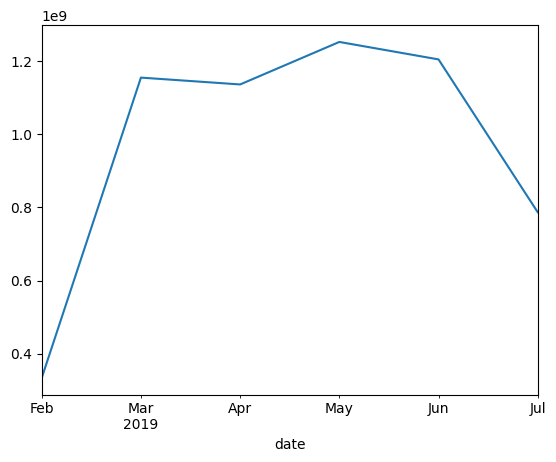

In [42]:
# This datatset has only one column
# Resample along month
dated_df.resample('m')['amountofmoney'].sum().plot()

<Axes: xlabel='date'>

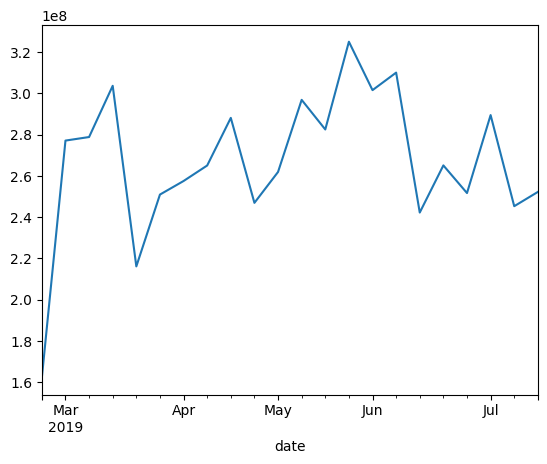

In [44]:
# Resample along week
dated_df.resample('w')['amountofmoney'].sum().plot()

## Vizualization

### Numerical Columns

In [15]:
def plot_num_cols(
    df: pd.DataFrame,
    num_cols: list[str],
    kind,
    subplots: tuple[int, int] = (2, 3),
    title: str | None = None,
    figsize: tuple[int, int] = (10, 6),
    savefig_path: str | None = None,
):
    fig, axes = plt.subplots(*subplots, figsize=figsize)

    if title:
        fig.suptitle(title)

    for ax, col in zip(axes.ravel(), num_cols):
        df[col].plot(kind=kind, ax=ax, title=col)

    plt.tight_layout()
    if savefig_path:
        plt.savefig(savefig_path)

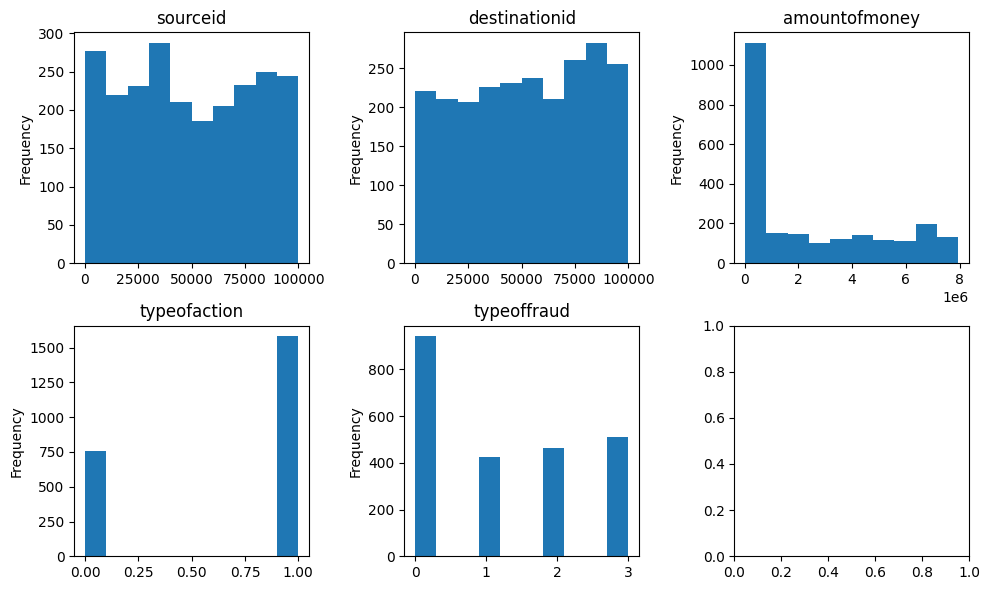

In [16]:
plot_num_cols(df, num_cols, 'hist')

In [27]:
df[num_cols].skew()

sourceid         0.042332
destinationid   -0.100452
amountofmoney    0.744457
typeofaction    -0.748785
typeoffraud      0.317553
dtype: float64

Here, `amountofmoney` is **highly positve skewed** with `0.744`.  
Also, a categorical column `typeofaction` is **highly negative skewed** with `-0.748`.

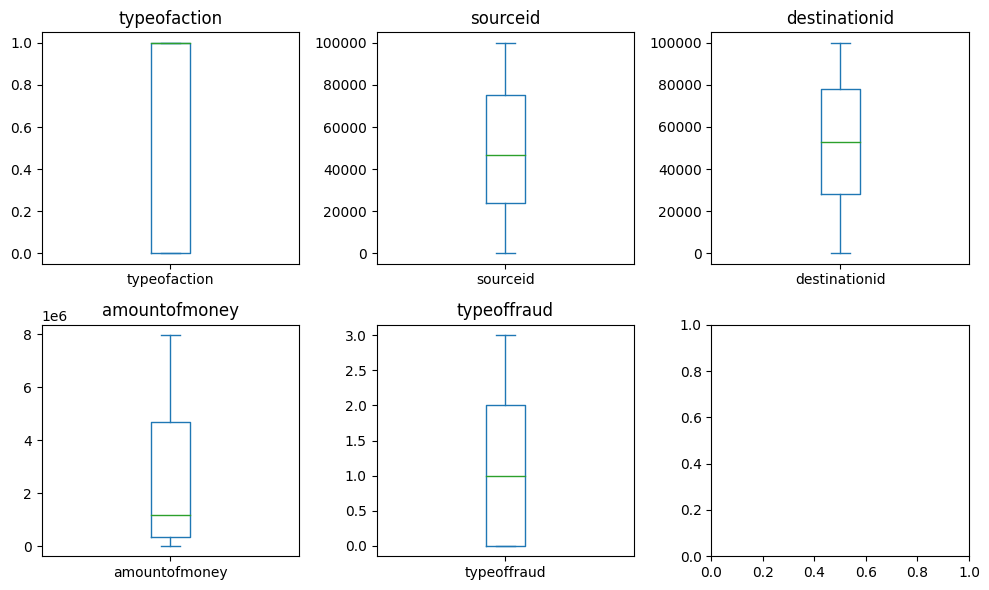

In [33]:
plot_num_cols(df, num_cols, 'box')

### Categorical Columns

In [19]:
def plot_cat_cols(
    df: pd.DataFrame,
    cat_cols: list[str],
    kind,
    subplots: tuple[int, int] = (1, 2),
    title: str | None = None,
    figsize = (10, 6),
    savefig_path: str | None = None,
):
    fig, axes = plt.subplots(*subplots, figsize=figsize)

    if title:
        fig.suptitle(title)

    plt.tight_layout()

    for ax, col in zip(axes.ravel(), cat_cols):
        df[col].value_counts().sort_index().plot(kind=kind, ax=ax)

    if savefig_path:
        plt.savefig(savefig_path)

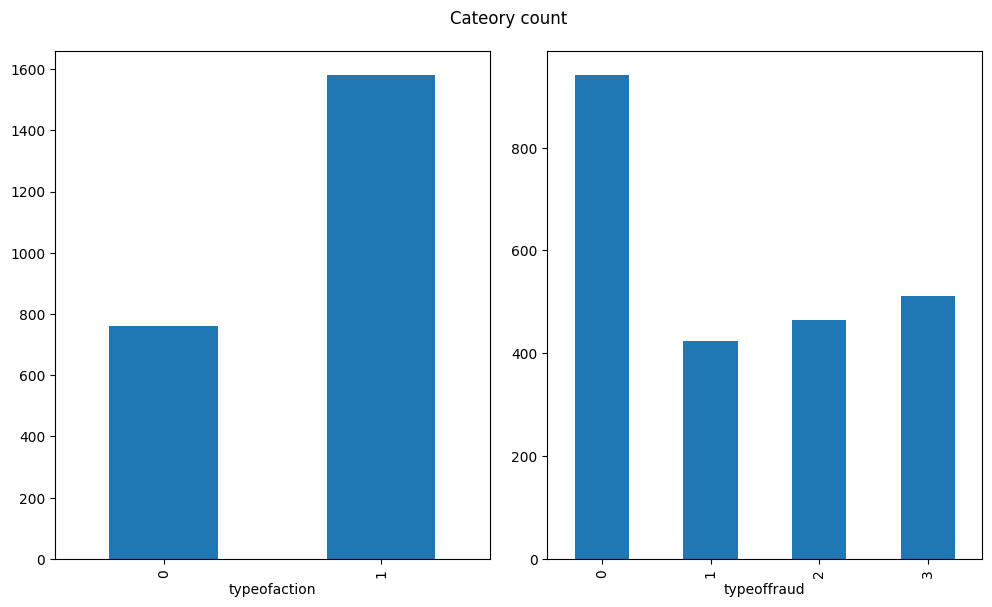

In [20]:
plot_cat_cols(df, cat_cols, 'bar', title='Cateory count')

### Multi Plots

<Axes: >

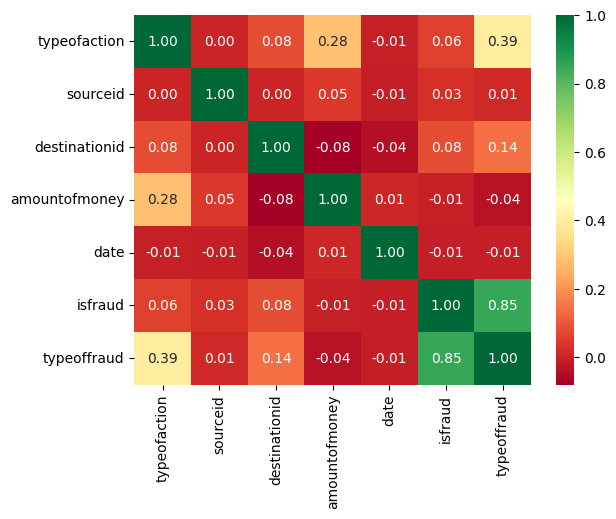

In [ ]:
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='RdYlGn', cbar=True)

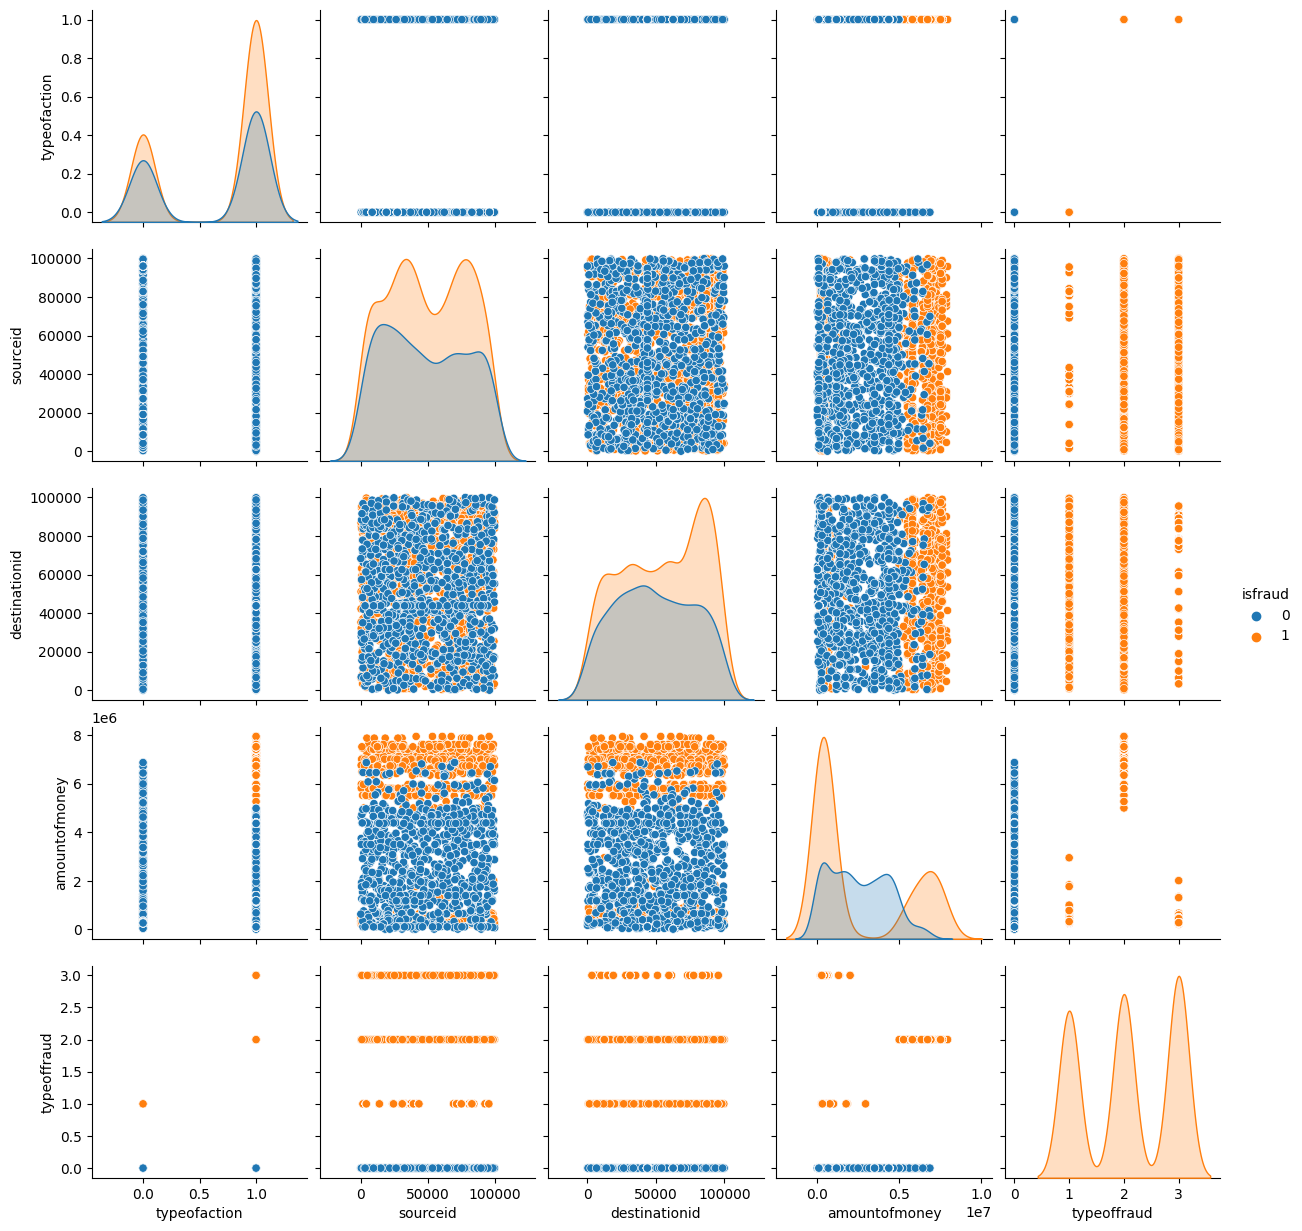

In [ ]:
sns.pairplot(df.drop(columns=[date_col]), hue=target)

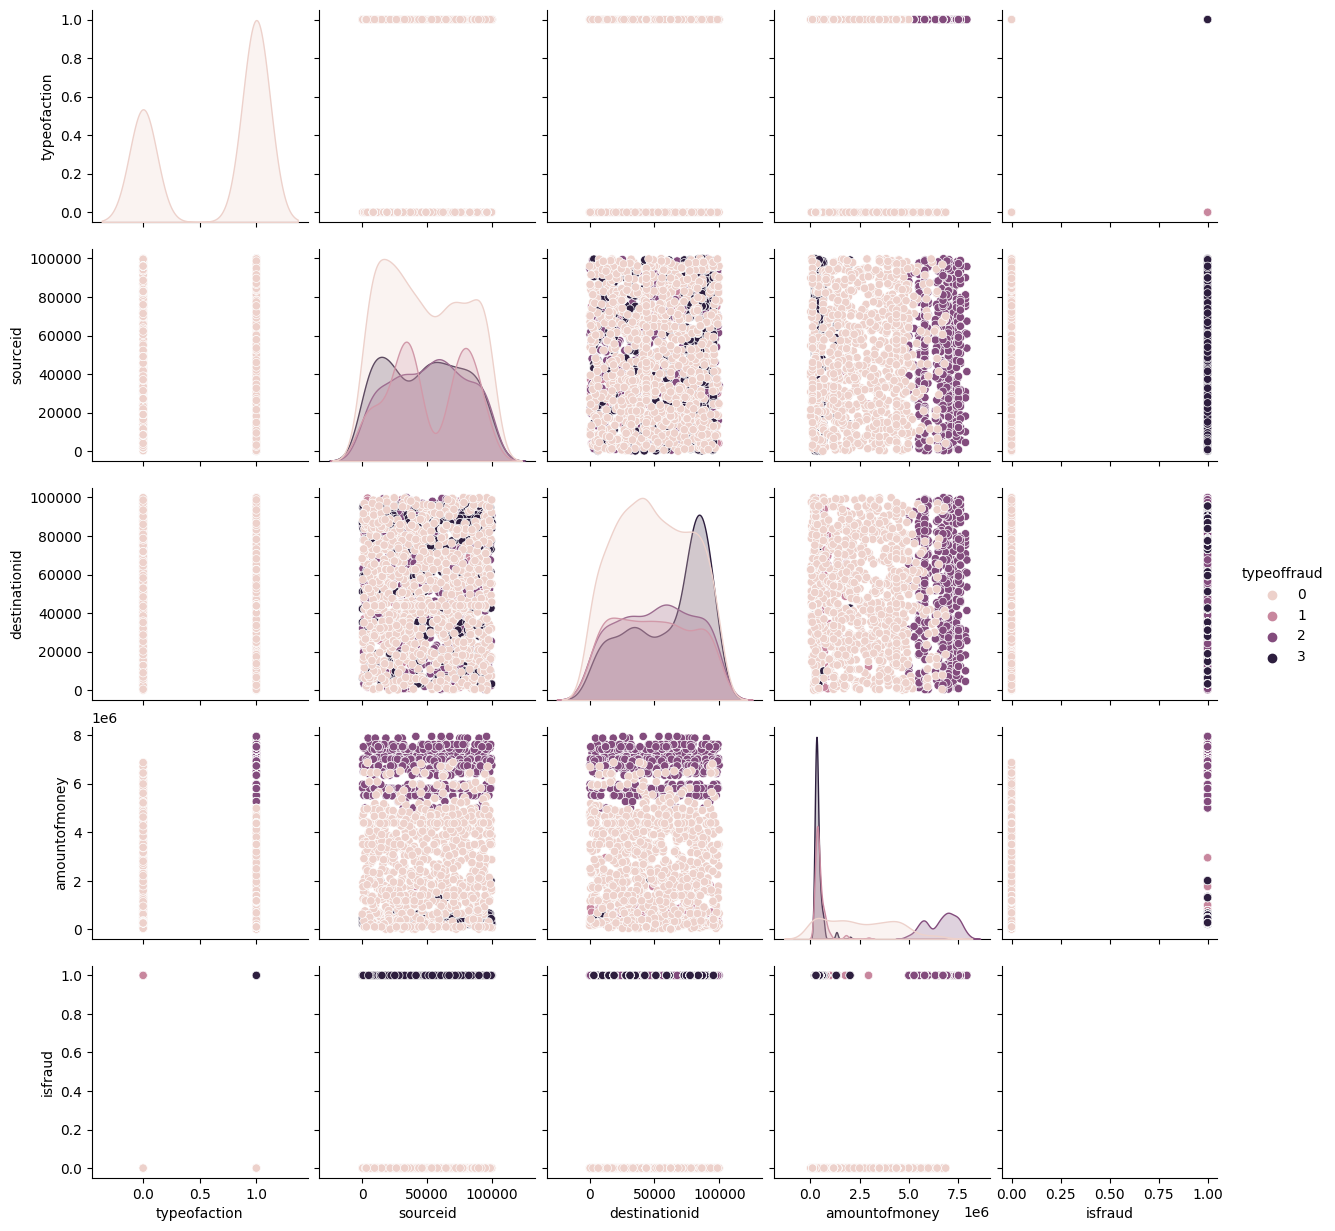

In [ ]:
sns.pairplot(df.drop(columns=[date_col]), hue='typeoffraud')

## ---